<a href="https://colab.research.google.com/github/SimonSanfeliu/Clase5/blob/master/Actividad5_Clasificacion_de_galaxias_estrellas_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EI2001: Ciencia de Datos en Astronomía
**Profesores:** Pía Cortés, Daniela Barrientos, Matías Suazo, Matías Mattamala

# Actividad Clase 5 - Clasificación con Machine Learning
## Separando estrellas de galaxias con los datos de SDSS

**Objetivos:** 
1. Introducción al Machine Learning en Python
2. Librería Scikit Learn
3. Uso de Métodos de clasificacion
4. Preaparacion de datos
5. Creacion de Modelo
6. Clasificación
 
 

Antes de comenzar la actividad, instalaremos el paquete de descarga de bases de datos astronómicas  [`astroquery`](https://astroquery.readthedocs.io/en/latest/). 

Ejecuta la siguiente celda, que realizará la instalación del paquete en tu entorno de ejecución temporal. 

In [1]:
# Al agregar ! convertimos nuestro codigo de python a bash (lenguaje usado en la terminal)
!pip install --pre  --quiet astroquery

    100% |████████████████████████████████| 4.2MB 5.7MB/s 
    100% |████████████████████████████████| 2.3MB 12.0MB/s 
    100% |████████████████████████████████| 61kB 21.4MB/s 
    100% |████████████████████████████████| 102kB 29.9MB/s 


# Motivación 
## ¿Por qué usar algoritmos de Aprendizaje de Máquinas?


Muchas de las aplicaciones de la ciencia hecha a partir de surveys astronómicos, dependen de la clasificación inicial de los objetos observados. Por ejemplo, pongámonos en el caso de querer estudiar la estructura de la Vía Láctea a partir de observaciones como las de SDSS o futuramente LSST. Estas imágenes contienen tanto estrellas locales como galaxias en sus imágenes, por lo que el paso cero de nuestra investigación sería separar las estrellas de las galaxias en nuestros catálogos. 

Ahora, ¿por qué es necesario usar Machine Learning para esto? 

Generalmente obtener una clasificación es caro. En el contexto de nuestro problema de estrellas versus galaxias, la clasificación real es confirmada mediante espectroscopía. Pero, obtener espectros requiere de tiempos de exposición mayores y no se realiza para todas las fuentes. En SDSS existen $\gt 10^{8}$ fuentes, de las cuales solo $\sim 10^{6}$ tienen espectros.

![Espectros](https://raw.githubusercontent.com/astrodatos/Clase5/master/imagenes/espectros.png)

Por otro lado, podemos hacernos una idea de la clasificación entre estrella y galaxia mirando las imágenes, las estrellas son objetos puntuales, mientras que las galaxias son extendidas. Pero esto necesitaría de una inspección visual para cada fuente en el catálogo, lo que nuevamente, es muy caro.

![Imágen Estrella](https://raw.githubusercontent.com/astrodatos/Clase5/master/imagenes/estrella.png =300x300)      ![Imágen Galaxia](https://github.com/astrodatos/Clase5/raw/master/imagenes/gal.png =300x300)

Aquí es donde el Machine Learning puede ayudarnos. A través del uso de algoritmos de ML podemos encontrar una separación de los objetos en nuestros catálogos en el espacio de múltiples de sus atributos. Muchas veces esta separación sucede en un espacio de varias dimensiones, que seríamos incapaces de detectar de otro modo.

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from mpl_toolkits import mplot3d

%matplotlib inline
#%matplotlib notebook


#Cambiar formato de graficos

plt.rcParams.update({'axes.labelsize' : 18})
plt.rcParams.update({'axes.titlesize' : 20})
plt.rcParams.update({'legend.fontsize' : 15})

El siguiente es un ejemplo de cómo aumentar las dimensiones a veces revela separaciones en nuestros datos. 

In [0]:
# Definimos las posiciones para 3 nubes de puntos

b1_x = np.random.normal(2, 0.5, 100) 
b2_x = np.random.normal(1, 0.5, 100)
b3_x = np.random.normal(5, 0.5, 100)

b1_y = np.random.normal(1, 0.5, 100) 
b2_y = np.random.normal(1, 0.5, 100)
b3_y = np.random.normal(5, 0.5, 100)

b1_z = np.random.normal(1, 0.5, 100) 
b2_z = np.random.normal(5, 0.5, 100)
b3_z = np.random.normal(5, 0.5, 100)

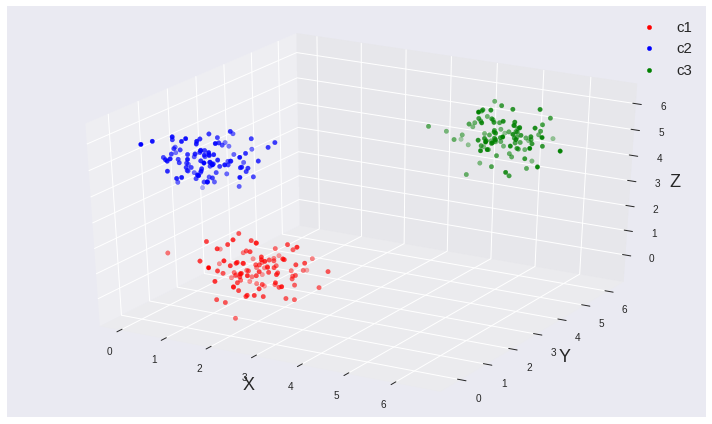

In [6]:
fig = plt.figure(figsize = (10,6))
ax = plt.axes(projection='3d')
ax.scatter3D(b1_x,b1_y,b1_z, color = 'r', label = 'c1')
ax.scatter3D(b2_x,b2_y,b2_z, color = 'b', label = 'c2')
ax.scatter3D(b3_x,b3_y,b3_z, color = 'g', label = 'c3')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

#ax.view_init(90, 90)
ax.legend()
plt.tight_layout()

# Preparación de Datos

## Sloan Digital Sky Survey ([SDSS](https://www.sdss.org/))


Los datos que utilizaremos para crear nuestro modelo de clasificación provendran del Sloan Digital Sky Survey, un proyecto astronómico que mapeó distintas zonas del cielo realizando tanto imágenes como espectros para una cantidad enorme de fuentes. 

Esto nos da la ventaja de obtener tanto los atributos, en este caso la fotometría, como las clases, que fueron obtenidas mediante espectros, a partir del mismo set de datos.

La gente de SDSS además de obtener los espectros e imágenes 'crudas' en multiples bandas, procesó estos datos para obtener la fotometría y una serie de parámetros por fuente. (Puedes mirar la lista de parámetros y sus definiciones [aqui](http://skyserver.sdss.org/dr15/en/help/browser/browser.aspx#&&history=description+PhotoObjAll+U)).

No podemos usar las 454  propiedades calculadas por objeto, es por esto que el primer paso en la construcción de nuestro clasificador será elegir los atributos a utilizar en esta clasificación.  

Para este ejemplo básico nos limitaremos a utilizar solo la fotometría en la banda r, obtenida mediante diferentes modelamientos.
 
 


### Cargar Datos desde SDSS

El paquete de python `astroquery` nos provee de una herramienta para acceder a las bases de datos de múltiples surveys astronómicos. En este caso utilizaremos sus módulos para extraer datos de SDSS. 

El formato para realizar la petición es la siguiente:

* __SELECT__: columnas que se quiere obtener.
  * Fotometría en la banda r, para distintos modelos fotométricos.
    * Atributos: `psfMag_r`, `fiberMag_r`, `fiber2Mag_r`, `petroMag_r`, `devMag_r`, `expMag_r`,
  `modelMag_r`, `cModelMag_r`
    * Clases: `class`  
  

* __FROM__: tabla desde donde obtener datos.
  * Fotometría desde `PhotoObjAll` y clases de `specObjAll`.

* __WHERE__: condiciones para elegir las fuentes.
  * Se eligen objetos con buena fotometría y que solo sean de las clases Star y Galaxy.


In [0]:
from astroquery.sdss import SDSS

In [8]:
# Vamos a seleccionar 20000 objetos de los catálogos de SDSS

data = SDSS.query_sql("""SELECT TOP 20000
                      p.psfMag_r, p.fiberMag_r, p.fiber2Mag_r, p.petroMag_r, 
                      p.deVMag_r, p.expMag_r, p.modelMag_r, p.cModelMag_r, 
                      s.class
                      
                      FROM PhotoObjAll AS p JOIN specObjAll s ON s.bestobjid = p.objid
                      
                      WHERE p.mode = 1 AND s.sciencePrimary = 1 AND p.clean = 1 AND s.class != 'QSO'
                      
                      """)

/usr/local/lib/python3.6/dist-packages/astroquery/sdss/core.py:865: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  comments='#'))


In [0]:
# Cambiamos el formato de la tabla obtenida con astroquery a pandas.

data_df = data.to_pandas()

In [10]:
# Miremos los primeros 10 objetos

data_df[:10]

,psfMag_r,fiberMag_r,fiber2Mag_r,petroMag_r,deVMag_r,expMag_r,modelMag_r,cModelMag_r,class
0,20.44020,20.78680,21.41974,19.63153,19.44181,19.65987,19.44181,19.49099,b'GALAXY'
1,20.59600,21.05023,21.52178,20.43809,20.55688,20.56577,20.55688,20.55688,b'STAR'
2,21.20326,21.68447,22.09465,21.44075,21.21554,21.21564,21.21554,21.21554,b'STAR'
3,21.11595,21.52400,22.05365,20.81025,20.74396,20.82218,20.74391,20.74396,b'GALAXY'
4,21.80693,22.16929,22.75302,20.35699,20.21300,20.49648,20.21300,20.21300,b'GALAXY'
5,15.98328,16.41668,16.88486,15.98777,15.94697,15.94905,15.94699,15.94697,b'STAR'
6,16.68552,17.12568,17.57669,16.71330,16.67639,16.67668,16.67637,16.67639,b'STAR'
7,18.25441,18.69980,19.15737,18.30059,18.25142,18.25123,18.25123,18.25123,b'STAR'
8,17.12955,17.56870,18.03390,17.14277,17.11263,17.11221,17.11264,17.11263,b'STAR'
9,18.41311,18.85497,19.31369,18.44023,18.40759,18.40755,18.40754,18.40755,b'STAR'


Como podemos ver, nuestra tabla contiene 8 columnas de atributos y una columna con las clases: 'STAR' y 'GALAXY'.

### Visualizacion de los datos

Siempre es bueno, antes de comenzar cualquier proyecto científico, hacer una exploración visual de nuestros datos. 

Queremos hacernos una idea general del comportamiento de nuestros datos. Como, qué atributos parecen más importantes, si existen separaciones marcadas en algunas de las características, etc. 

Vamos a utilizar el método  [`pairplot`](https://seaborn.pydata.org/generated/seaborn.pairplot.html) del paquete `Seaborn`, para graficar tanto las distribuciones de nuestros parámetros como las relaciones entre ellos. 


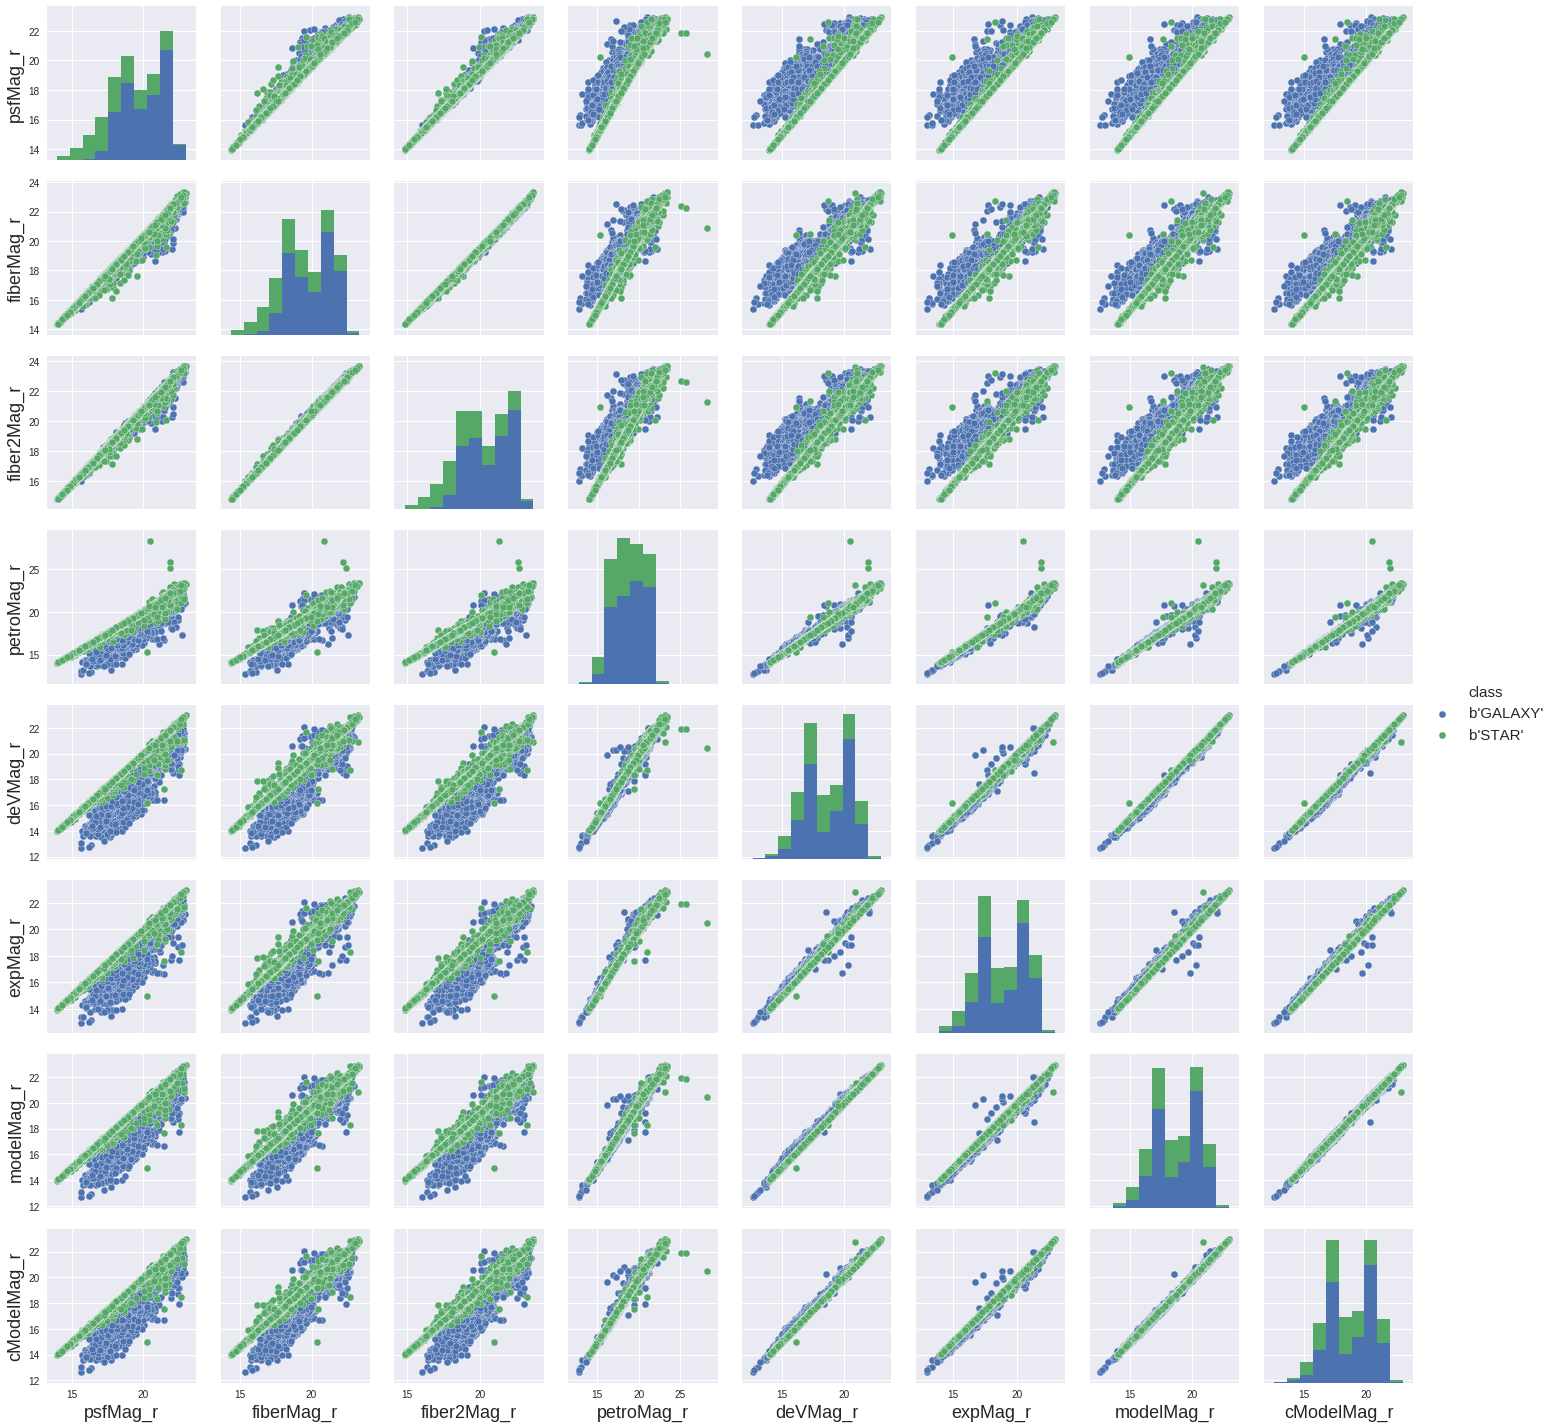

In [11]:
sns.pairplot(data_df, hue = 'class', diag_kind = 'hist')

Hay alguna separacion obvia? Miremos más de cerca algunos de los atributos.

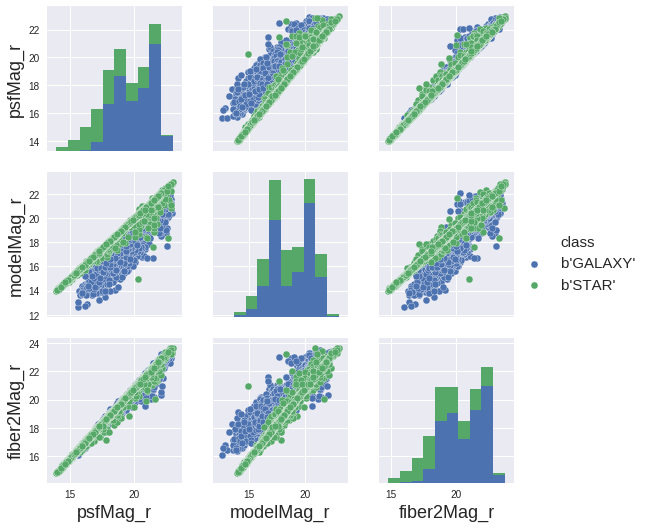

In [12]:
sns.pairplot(data_df[['psfMag_r', 'modelMag_r', 'fiber2Mag_r', 'class']], hue = 'class')

### Separacion de Datos

Como vimos en la Clase 5, el procedimiento estándar al realizar Aprendizaje Supervisado (cuando tenemos clases para nuestros objetos) es entrenar nuestro modelo en una porción de nuestros datos, para luego probar su precisión en lo que resta de ellos. 

Además debemos separar nuestra tabla en dos, una que contenga los atributos y otra que contenga las clases. 


In [13]:
# Miremos primero la lista con los nombres de las columnas
list(data_df)

['psfMag_r',
 'fiberMag_r',
 'fiber2Mag_r',
 'petroMag_r',
 'deVMag_r',
 'expMag_r',
 'modelMag_r',
 'cModelMag_r',
 'class']

Para realizar la construcción de nuestros modelos utilizaremos el paquete de Python [`Scikit Learn`](https://scikit-learn.org/stable/). Scikit learn requiere que nuestros datos esten en alguna estructura de datos donde las columnas sean los atributos y las filas los objetos. 

Pero es necesario que nuestros atributos y clases tengan un formato numérico. Afortunadamente, en Astronomía la mayoría de las veces vamos a tratar con atributos numéricos y no es necesario tanto procesamiento. 

En este caso solo debemos preocuparnos de transformar las clases, ya que de momento son _strings_. 

In [0]:
# Primero identificamos las clases existentes 

clases = data_df['class'].unique()

mapa = {}

for clase, i in enumerate(clases):
    mapa[i] = clase

In [15]:
# Creamos un mapeo entre las clases originales (strings) y las nuevas (enteros)
mapa

{b'GALAXY': 0, b'STAR': 1}

In [0]:
# Separamos entre atributos y clases (cambiando el formato de las clases)

X = np.array(data_df.iloc[:,:-1])          # Arreglo con atributos


y = np.array(data_df['class'].map(mapa))   # Arreglo con clases 0 y 1

Una cosa importante de considerar al hacer la separación de nuestros datos en sets de entrenamiento y prueba, es la distribución de las clases en ellos. La separación debe ser realizada de tal forma que todas las clases esten representadas en ambos conjuntos. 

In [0]:
# Usamos una funcion de scikit learn para dividir nuestro conjunto al azar

from sklearn.model_selection import train_test_split

rs = 1851   #Guardamos la semilla 
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = rs)

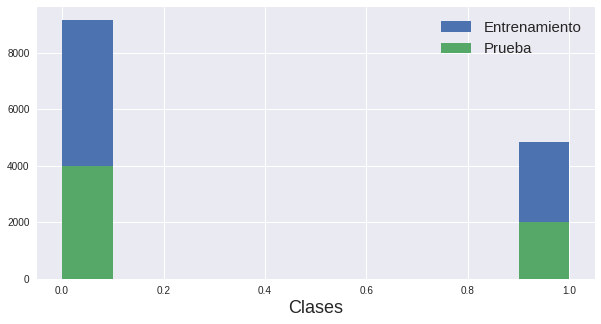

In [18]:
# Veamos las distribuciones de clases para cada set

plt.figure(figsize = (10,5))

plt.hist(train_y, label = 'Entrenamiento')
plt.hist(test_y, label = 'Prueba')
plt.xlabel('Clases')
plt.legend()

## Creación del Modelo de Clasificación.

Ahora que separamos nuestro conjunto de datos estamos listos para crear nuestro modelo de clasificación. Existen varios modelos que podemos usar para realizar Aprendizaje Supervisado [implementados en scikit-learn](https://scikit-learn.org/stable/supervised_learning.html). Para este caso de ejemplo, utilizaremos un clasificador llamado _k Nearest Neighbors_.


### K Nearest Neighbors (kNN) - k Vecinos mas próximos.

La clasificación se realiza en base a las clases de los vecinos más proximos, para un cierto $k$ se realiza un conteo de las clases correspondientes a los $k$ vecinos más próximos y se asigna al nuevo objeto la clase más popular. 

![texto alternativo](https://thumbs.gfycat.com/WildSorrowfulChevrotain-size_restricted.gif)


La clasificación, luego, va a depender de la __cantidad de vecinos a considerar__. 

(Nota que para poder utilizar este algoritmo debemos evaluar la distancia entre nuestros objetos, lo que podría ser problemático dependiendo del tipo de datos que tengamos).

![texto alternativo](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/KnnClassification.svg/279px-KnnClassification.svg.png =400x350)

([scikit learn kNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html))



#### Inincializar un modelo

In [0]:
# Vamos a utilizar la implementacion del algoritmo knn de scikitlearn

from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=25)   # Debemos especificar el numero
                                                 #de vecinos, en este caso escogemos 25

In [20]:
knn_clf

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=25, p=2,
           weights='uniform')

#### Ajustar a los datos

Esta es la fase de _entrenamiento_ de nuestro modelo. Aqui es cuando nuestro modelo aprenderá la clasificación a partir de los datos en el conjunto de entrenamiento.

En `scikit-learn`, esto es tan fácil como utilizar el método:

__`modelo.fit(atributos, clases)`__

In [21]:
# Utilizamos el metodo .fit para entrenar nuestro clasificador

knn_clf.fit(train_X, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=25, p=2,
           weights='uniform')

#### Testear modelo haciendo predicciones

Una vez entrenado nuestro modelo, podemos hacer clasificaciones para datos independientes. En esta fase vamos a validar la precisión de nuestro clasificador. 

Para esto haremos uso del conjunto de datos de prueba. Nuestra estrategia será predecir clases para cada objeto en nuestro conjunto a partir de sus atributos y luego comparar estas con la clases reales.

En scikit-learn las predicciones se hacen mediante el método:

__`modelo.predict(atributos)`__

In [0]:
# Hacemos la clasificacion del set de prueba

pred_test = knn_clf.predict(test_X)

In [23]:
pred_test

array([0, 1, 0, ..., 0, 0, 1])

In [24]:
test_y

array([0, 1, 0, ..., 0, 0, 1])

Al igual que nuestras clases, el resultado de las predicciones es un arreglo de 0s y 1s, representando la clasificación entre galaxias y estrellas. Podemos ver que tan precisa es esta clasificación comparando estas etiquetas.

Text(0.5, 0, 'Clase Predicha - Clase Real')

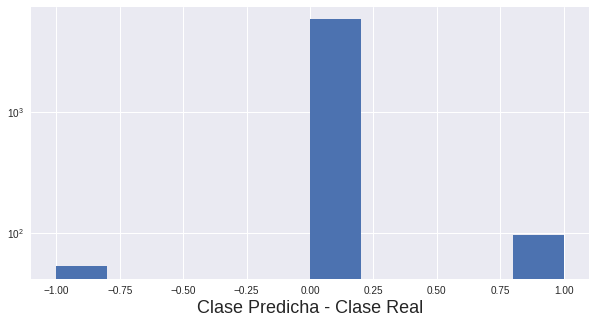

In [25]:
plt.figure(figsize=(10,5))
plt.hist(pred_test - test_y)
plt.yscale('log')
plt.xlabel('Clase Predicha - Clase Real')

## Matriz de Confusión

Una forma estándar y sencilla de evaluar la precisión de un modelo de aprendizaje supervisado es a través de la Matriz de Confusión. 

En esta matriz las __columnas__ representan las __predicciones__ hechas para cada clase, mientras que las __filas__ representan las instancias de la clase real. 

Las matrices de confusión son muy buenas para identificar cuando el algoritmo esta confundiendo dos clases específicamente. 

![texto alternativo](https://sandipanweb.files.wordpress.com/2017/07/confusion.png?w=676)

In [0]:
# Utilizaremos la implementación de scikit-learn de esta matriz

from sklearn.metrics import confusion_matrix

In [27]:
# Obtengamos nuestra matriz de confusion

confusion_matrix(test_y, pred_test)

array([[3880,   96],
       [  53, 1971]])

Scikit-learn nos ofrece una implementación gráfica de la Matriz de Confusión, que nos permite ver sencillamente (con colores) el rendimiento de nuestro algoritmo.

[Fuente del código para la matriz de confusión implementada](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py)

In [0]:
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Matriz de confusion normalizada'
        else:
            title = 'Matriz de confusion, sin normalizacion'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusion normalizada")
    else:
        print('Matriz de confusion, sin normalizacion')

    print(cm)

    fig, ax = plt.subplots(figsize = (8,8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Etiqueta Real',
           xlabel='Etiqueta Predicha')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor", fontsize=15)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), fontsize=25,
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
            
    ax.grid(False)
    fig.tight_layout()
    return ax

Matriz de confusion, sin normalizacion
[[3880   96]
 [  53 1971]]


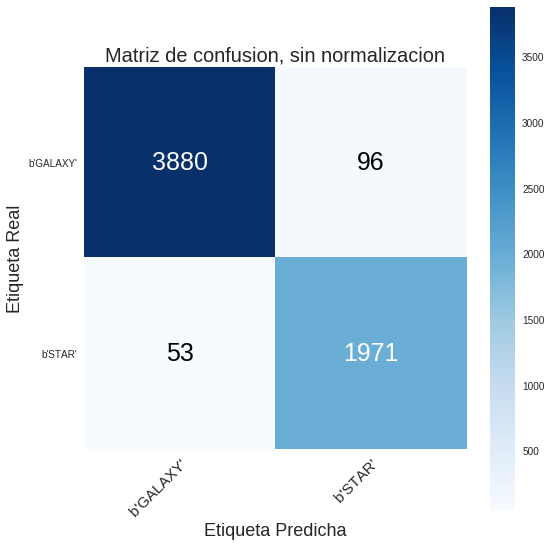

In [29]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(test_y, pred_test, classes=clases,
                      title='Matriz de confusion, sin normalizacion')

Matriz de confusion normalizada
[[0.98 0.02]
 [0.03 0.97]]


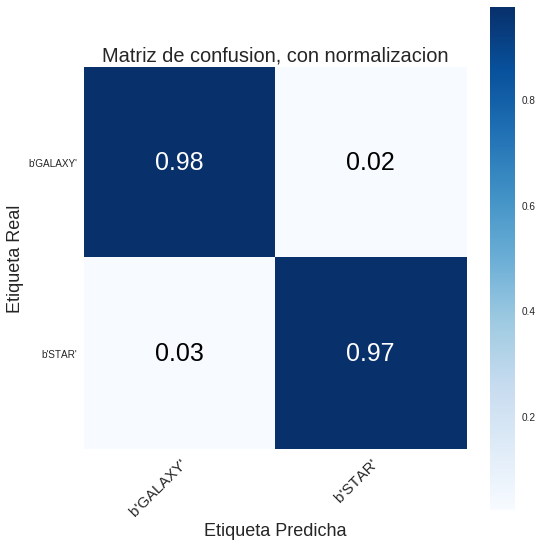

In [30]:
plot_confusion_matrix(test_y, pred_test, classes=clases, normalize = True,
                      title='Matriz de confusion, con normalizacion')